# AI-driven Interactive Metadata 

*Amanda Birmingham, Dept. of Pediatrics, UC San Diego*

A natural-language approach to metadata investigation and cleaning using the `ChatGPT 4` LLM, the `Langchain` AI framework, and AI-based speech recognition.

## Initial set-up

To be performed outside notebook:

## Adjustable LLM settings

In [1]:
import os
g_GEMINI = "GOOGLE_API_KEY"
g_CHATGPT = os.environ['OPENAI_API_KEY']

g_chosen_llm = g_CHATGPT

In [2]:
g_use_speech = True

In [3]:
# WARNING: Increasing this number will increase the amount of information included in each 
# LLM query and thus increase the cost of the queries!
# Decreasing this number will make the LLM forget past exchanges more quickly
g_num_msgs_in_history = 4

In [4]:
g_base_prompt = f"using pandas 3 and python 3.10+ to clean data in jupyter lab."
g_ds_prompt = f"You are a data scientist {g_base_prompt}"
g_pf_prompt = f"You are a professor of data science teaching a class on {g_base_prompt}." 

## Imports

In [5]:
import pandas as pd
import numpy as np
import re

In [6]:
import ipywidgets as widgets
from IPython import get_ipython
from IPython.display import display
import threading
from traitlets import observe, link, Unicode, Bool, Any
#from itables import init_notebook_mode, show
from ipylab import JupyterFrontEnd
import time

In [7]:
import sounddevice as sd
from scipy.io.wavfile import write
# import subprocess
from openai import OpenAI

In [8]:
import speech_recognition as speech_recog

In [9]:
from langchain_core.messages import trim_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

In [10]:
import warnings
# warnings.filterwarnings('ignore')

In [11]:
import logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(level=logging.WARNING, format='%(levelname)s: %(message)s')

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Model creation

In [13]:
# assert g_chosen_llm in os.environ, f"Please set the {g_chosen_llm} environment variable."

In [14]:
if g_chosen_llm == g_CHATGPT:
    from langchain_openai import ChatOpenAI
    _g_chat_model = ChatOpenAI(model="gpt-4o-mini")
elif g_chosen_llm == g_GEMINI:
    from langchain_google_genai import ChatGoogleGenerativeAI
    _g_chat_model = ChatGoogleGenerativeAI(
        model="gemini-1.5-pro",
        temperature=0,
        max_tokens=None,
        timeout=None,
        max_retries=2,
    )
else:
    raise ValueError(f"Unrecognized llm model '{g_chosen_llm}'")

## Chat creation

In [15]:
def _start_chat(model, custom_prompt):    
    # Define trimmer
    # count each message as 1 "token" (token_counter=len) and 
    #keep only the last x messages
    trimmer = trim_messages(strategy="last", max_tokens=g_num_msgs_in_history, 
                            token_counter=len)
    
    workflow = StateGraph(state_schema=MessagesState)
    
    # Define the function that calls the model
    def call_model(state: MessagesState):
        trimmed_messages = trimmer.invoke(state["messages"])
        system_prompt = custom_prompt
        messages = [SystemMessage(content=system_prompt)] + trimmed_messages
        response = model.invoke(messages)
        return {"messages": response}
    
    
    # Define the node and edge
    workflow.add_node("model", call_model)
    workflow.add_edge(START, "model")
    
    # Add simple in-memory checkpointer
    memory = MemorySaver()
    app = workflow.compile(checkpointer=memory)
    return app

In [16]:
_g_chat = _start_chat(_g_chat_model, g_ds_prompt)

In [17]:
# AB: Moved front end helpers later

## Prompt engineering

In [18]:
# ai helper prompts
g_unique_set_prefix = "for column named"
g_col_check_prefix = "check column named"
g_code_prefix = "write code to"

# AB: modified and extended
# function helper prompts
g_summarize_statement = "summarize table"
g_summarize_col_statement = "summarize column named"
g_explore_col_statement = "explore column named"

# button prompts
g_add_cell_statement = "add cell"
g_copy_last_statement = "copy it"
g_run_last_statement = "now run it"
g_revert_df_statement = "revert dataframe"

In [19]:
def _remove_known_str(a_prompt, known_str):
    return a_prompt.replace(known_str, "").strip()


def _change_first_char(a_str, upper=True):
    if upper:
        a_lambda = lambda x: x.groups()[0].upper()
    else:
        a_lambda = lambda x: x.groups()[0].lower()
        
    # affect ONLY first letter, leave all the rest alone
    # (so different that a_str.capitialize() or a_str.title())
    return re.sub('([a-zA-Z])', a_lambda, a_str, count=1)   


def _expand_prompt(user_prompt, df_name, a_df):
    df_prompt = f"You are given the '{df_name}' dataframe with columns {list(a_df.columns)}. "
    
    if user_prompt.startswith(g_col_check_prefix):
        col_name = _remove_known_str(user_prompt, g_col_check_prefix)
        col_name = col_name.replace(" ", "_")
        user_prompt = _get_explore_col_prompt(col_name)     
    # end if starts with check prefix--which itself adds a unique set prefix
    
    if user_prompt.startswith(g_unique_set_prefix):
        new_prompt = _get_unique_set_prompt(user_prompt, a_df)
    elif user_prompt.startswith(g_code_prefix):
        new_prompt = _get_code_prompt(user_prompt)        
    else:
        new_prompt = user_prompt

    new_prompt = df_prompt + new_prompt

    return new_prompt


def _get_explore_col_prompt(col_name):
    # explore_prompt = "suggest the appropriate Pandas data type for the values in this column, very briefly hypothesize about what they represent, and indicate if any look invalid or unexpected." # Please keep responses short and to the point."
    explore_prompt = ("suggest the appropriate Pandas data type for the values in this column, "
                      "say 'Column is thought to be xxx' where xxx is either identifier, categorical, or numeric. "
                      "Do not format."
                     "very briefly hypothesize about what they represent, and indicate if any "
                      "look invalid or unexpected.") # Please keep responses short and to the point."
    
    col_prompt = f"{g_unique_set_prefix} {col_name}, {explore_prompt}"
    return col_prompt


def _get_unique_set_prompt(user_prompt, a_df):
    err_msg = f"Please phrase your question as {g_unique_set_prefix} <col_name>, <question about unique values of column>"
    
    if not user_prompt.startswith(g_unique_set_prefix):
        return err_msg

    prompt_split = user_prompt.split(",")
    if len(prompt_split) < 2:
        return err_msg

    col_name = prompt_split[0].replace(g_unique_set_prefix, "").strip()
    new_prompt = f"For the column named '{col_name}' containing the set of values  {set(a_df[col_name])}, {','.join(prompt_split[1:])}"
    return new_prompt


def _get_code_prompt(user_prompt):
    err_msg = f"Please phrase your question as {g_code_prefix} <perform some operation>"
    
    if not user_prompt.startswith(g_code_prefix):
        return err_msg

    new_prompt = f"{user_prompt} Do not include any non-comment explanations, import statements, or the instantiation of the dataframe. Do not include markdown formatting in your output. Provide runnable code as output."
    return new_prompt

In [20]:
import re

# Example string
text = "Some initial text. Column is thought to be categorical. Some more text."

def find_cat(text):
    # Regular expression to find the pattern and capture the word
    match = re.search(r'Column is thought to be (identifier|categorical|numerical)', text)
    if match:
        result = match.group(1)  # This will contain only the word 'identifier', 'categorical', or 'numerical'
    return result

## State management

In [21]:
_g_last_code_out = {}
_g_last_working_df = {}

In [22]:
_g_LAST_CODE_NAME = "AI-generated code"
_g_LAST_DF_NAME = "g_working_df"   

# AB: added get-default functions
def _get_df_name(df_name):
    return df_name if df_name is not None else _g_LAST_DF_NAME


# TODO: this could be used to replace a lot of existing checks
def _get_df(a_df):
    return a_df if a_df is not None else g_working_df


def _save_state(state_dict, obj_to_save, state_name, use_last_execution_num=False):
    # this does NOT copy the input obj_to_save before saving it--that should happen outside this call, if needed
    execution_num = get_ipython().execution_count
    if use_last_execution_num:
        execution_num = execution_num - 1
    
    if execution_num in state_dict:
        warnings.warn(f"{state_name} already contains state for a cell with execution number {execution_num}, which will be overwritten.")
    state_dict[execution_num] = obj_to_save
    return state_dict


def _get_last_state(state_dict):
    last_value = None
    if state_dict is not None and len(state_dict)>0:
        last_key, last_value = next(reversed(state_dict.items()))
    return last_value


def _df_changed():
    #print("in _df_changed")
    last_working_df = _get_last_state(_g_last_working_df)

    if last_working_df is not None:
        #print(f"g_working_df cols: {g_working_df.columns}")
        #print(f"last_working_df cols: {last_working_df.columns}")
        if not last_working_df.equals(g_working_df):
            #print("are different")
            return True
    return False


def _revert_df():
    global g_working_df
    msg = f"There is no {_g_LAST_DF_NAME} state stored." 

    last_working_df = _get_last_state(_g_last_working_df)
    if last_working_df is not None:
        if _df_changed():
            store_working_df()
            g_working_df = last_working_df
            msg = f"{_g_LAST_DF_NAME} reverted to last saved state."
        else:
            msg = f"{_g_LAST_DF_NAME} has not changed since last saved state."
    return msg


def store_working_df(a_df=None, use_last_execution_num=False):
    if a_df is None:
        a_df = g_working_df.copy()
    _save_state(_g_last_working_df, a_df, _g_LAST_DF_NAME, use_last_execution_num=use_last_execution_num)


def revert_df():
    statement = _revert_df()
    return statement


# decorator
def stateful(func):
    def wrapper(*args, **kwargs):
        if _df_changed():
            store_working_df(use_last_execution_num=True)
        func(*args, **kwargs)
    return wrapper

## Front-end helpers

In [23]:
_g_front_end = JupyterFrontEnd()

In [24]:
def _set_raw():
    _g_front_end.commands.execute('notebook:change-cell-to-raw')
    

def _insert_and_populate(statement=None, move_up=True):
    _g_front_end.commands.execute('notebook:insert-cell-below')
    if statement is not None:
        time.sleep(0.2)
        _g_front_end.commands.execute('notebook:replace-selection', { 'text': statement})
        _g_front_end.commands.execute('notebook:enter-edit-mode')

    if move_up:
        _g_front_end.commands.execute('notebook:move-cell-up') 
        

def _insert_and_run(statement=None, move_up=True):
    _insert_and_populate(statement, move_up)
    
    if statement is not None:
        _g_front_end.commands.execute('notebook:run-cell-and-select-next')  
        _g_front_end.commands.execute('notebook:enter-edit-mode')


# AB: new
def _set_query_to_raw(up_twice=False):
    # move the cursor up to the query cell (the one running right now)
    # and set *it* to raw
    _g_front_end.commands.execute('notebook:move-cursor-up')
    if up_twice:
        _g_front_end.commands.execute('notebook:move-cursor-up')
    _set_raw()

    # move the cursor down TWICE: once from the query cell to the
    # cell holding its output (either a raw cell or a created code cell), 
    # and once more to whatever comes next
    _g_front_end.commands.execute('notebook:move-cursor-down')
    _g_front_end.commands.execute('notebook:move-cursor-down')    


def _set_query_and_output_to_raw(output):
    # creates a (code) cell containing the (non-code) output;
    # cursor is now on that new cell
    _insert_and_populate(output)

    # change now-current (new) cell to raw format
    _set_raw()

    _set_query_to_raw()


def _set_query_to_raw_and_run_code_cell(code_str):
    # print(code_str)
    _save_state(_g_last_code_out, code_str, _g_LAST_CODE_NAME)    # This isn't working correctly
    _insert_and_run(code_str, move_up=True)
    _set_query_to_raw(up_twice=True)  

## Chat helper function creation

In [25]:
# Instantiating an empty notebook allows prompt methods to bind to the 
# variable so the can use the real contents later without needing to be 
# passed an argument
g_working_df = pd.DataFrame()

In [26]:
# AB: reordered
@stateful
def find_problem_headers(a_df=None):
    a_df = a_df if a_df is not None else g_working_df

    invalid_cols = a_df.columns[a_df.columns.str.contains(r'[^a-zA-Z0-9._ ]', regex=True)]
    if len(invalid_cols) == 0:
        out = "No invalid column headers found."
    else:
        out = invalid_cols
    print(out)


@stateful
def scrub_headers(a_df=None, lcase_headers=True):
    a_df = a_df if a_df is not None else g_working_df

    a_df.columns = a_df.columns.str.replace(r'[^a-zA-Z0-9]', '_', regex=True)  
    a_df.columns = a_df.columns.str.replace(r'__+', '_', regex=True)  
    a_df.columns = a_df.columns.str.strip('_')
    if lcase_headers:
        a_df.columns = a_df.columns.str.lower()
    print(a_df.columns)


@stateful
def find_problem_records(a_df=None):
    a_df = a_df if a_df is not None else g_working_df

    # get records with leading or trailing spaces in any field
    problem_records = a_df[a_df.apply(lambda x: x.str.contains(r'^\s|\s$', na=False).any(), axis=1)]
    if len(problem_records) == 0:
        print("No problem records found.")
    else:
        display(problem_records)
        return problem_records


@stateful
def scrub_problem_records():
    global g_working_df
    
    # Remove leading or trailing spaces from any field in the dataframe
    g_working_df = g_working_df.map(lambda x: x.strip() if isinstance(x, str) else x)
    print("Problem records scrubbed.")


# AB: modified params list, added line for input coltype, modified wording for df coltype
def _deterministic_summarize_col(col_name, col_type_names, a_df=None, max_items_shown=None, visualize=True):
    a_df = _get_df(a_df)
    max_items_shown = max_items_shown if max_items_shown is not None else 10
    
    lines = []
    lines.append(f"{col_name}")
    lines.append("================")
    lines.append(f"{col_type_names[col_name]} type")
    a_col = a_df[col_name]
    
    summary = []
    col_uniques = a_col.unique()
    count_uniques = len(col_uniques)
    if a_col.is_unique:
        summary.append(f"All {count_uniques} values are unique.")
    else: 
        summary.append(f"There are {count_uniques} unique value(s) in {len(a_col)} total values.")
    # end if all are unique
        
    caveat = f"first {max_items_shown} " if count_uniques > max_items_shown else ""
    summary.append(f"The {caveat}unique value(s):{col_uniques[:max_items_shown]}.")
    lines.append(" ".join(summary))

    lines.append(f"The current dataframe datatype is {a_col.dtype}.")
    lines.append(" ")

    stats, plot = stats_from_col(col_name, col_type_names, a_df, max_items_shown, visualize)
    lines.extend(stats)

    if not visualize:
        plot = None
    return lines, plot


def stats_from_col(col_name, col_type_names, a_df, max_items_shown, visualize):

    type_of = col_type_names[col_name]

    stats = [] # List of lines
    plot = None
    
    if type_of == 'categorical':
        stats += categorical_stats(col_name, a_df)
        if visualize:
            plot = visualize_col_categorical(col_name, a_df)

    elif type_of == 'numeric':
        stats += numeric_stats(col_name, a_df)
        if visualize:
            plot = visualize_col_numeric(col_name, a_df)
        
    elif type_of == 'identifier':
        stats += id_stats(col_name, a_df)

    stats.append('\n')
    
    return stats, plot


In [27]:
# AB: moved some private _ask functions up up here to allow
# earlier use, added a few
def _ask(user_prompt, df_name=None, a_df=None):
    df_name = _get_df_name(df_name)
    a_df = _get_df(a_df)
    
    new_prompt = _expand_prompt(user_prompt, df_name, a_df)    
    result = _g_chat.invoke(
        {"messages": [HumanMessage(content=new_prompt)]},
        config={"configurable": {"thread_id": "1"}},
    )
    return new_prompt, result

def _get_result_text(a_result):
    return a_result.get("messages")[-1].content


def _clean_answer(answer_str):
    answer_str = re.sub("^```python\n", "", answer_str)
    answer_str = re.sub("\n```$", "", answer_str)   
    return answer_str
    

def _get_ask_txt(ask_result):  
    output = _get_result_text(ask_result)
    output = _clean_answer(output) 
    return output

In [28]:
# AB: Placeholder for DP's ai-type-guessing function
# TODO: replace

_id_type = 'identifier'
_cat_type = 'categorical'
_num_type = 'numeric'

# def _ai_get_col_types(df_name, a_df, col_names_list=None):
#     return {"sample_name":"string", "subjectid": "string", "body_site": "string", "age": "numeric", "sex": "string"}

def _ai_get_col_type_one(col_name, a_df=None, df_name=None):
    
    col = a_df[col_name]
    _, result = _ask(f'based on the following entries: {col}, in a column named {col_name} '
            f'is this categorical or numeric or identifier. Give a one word answer '
            f'either categorical or numeric or identifier.',
            df_name=df_name, a_df=a_df)

    t = _get_result_text(result)

    col_type = _id_type
    for poss_type in [_num_type, _cat_type]:
    	if poss_type in t.lower():
    		col_type = poss_type
    		break

    return col_type


def _ai_get_col_types(df_name, a_df, col_names_list=None):

    df_name = _get_df_name(df_name)
    a_df = _get_df(a_df)
    
    # Ignore warnings generated by multiple calls to ask from the same cell
    # warnings.filterwarnings('ignore')

    col_types = {}
    for col_name in a_df.columns:

        col_type = _ai_get_col_type_one(col_name, a_df=a_df, df_name=df_name)

        col_types[col_name] = col_type

    return col_types

## Summarize

In [29]:
# AB: Separated from contents of earlier deterministic prompts cell for clarity 
def _get_coltypes_str(col_types, col_names_list=None):
    if col_names_list == None:
        col_names_list = list(col_types.keys())
        
    min_col_types = {k: v for k, v in col_types.items() if k in col_names_list}
    min_coltypes_str = "{" + ", ".join(f'"{key}": "{value}"' for key, value 
                                   in min_col_types.items()) + "}"
    return min_coltypes_str


def _get_ai_coltypes_str(df_name, a_df, col_names_list=None):
    col_types = _ai_get_col_types(df_name, a_df, col_names_list)
    coltypes_str = _get_coltypes_str(col_types, col_names_list)
    return coltypes_str


def _ai_summarize_col(col_name, df_name, a_df, max_items_shown=None, visualize=True):
    one_coltypes_str = _get_ai_coltypes_str(df_name, a_df, col_names_list=[col_name])
    result = f"summarize_col('{col_name}', {one_coltypes_str}, df_name='{df_name}', a_df={df_name}, max_items_shown={max_items_shown}, visualize={visualize})"
    _set_query_to_raw_and_run_code_cell(result)
    # return result


def _ai_summarize(df_name, a_df, max_items_shown=None, visualize=False):
    coltypes_str = _get_ai_coltypes_str(df_name, a_df)
    result = f"summarize(col_types={coltypes_str}, df_name='{df_name}', a_df={df_name}, max_items_shown={max_items_shown}, visualize={visualize})"
    _set_query_to_raw_and_run_code_cell(result)


def _validate_column(col_name, a_df, df_name):
    if col_name not in a_df.columns:
        raise ValueError(f'Column {col_name} not found in {df_name}')

@stateful
def summarize_col(col_name, col_types=None, df_name=None, a_df=None, max_items_shown=None, visualize=True):
    df_name = _get_df_name(df_name)
    a_df = _get_df(a_df)
    
    _validate_column(col_name, a_df, df_name)
    
    if col_types is None:
        _ai_summarize_col(col_name, df_name, a_df, max_items_shown, visualize=visualize)
    else:
        result, plot = _deterministic_summarize_col(col_name, col_types, a_df, max_items_shown, visualize=visualize)
        result_str = "\n".join(result)
        print(result_str)
        if visualize:
            plt.show()


@stateful
def summarize(df_name=None, a_df=None, col_types=None, max_items_shown=None, visualize=False):
    df_name = _get_df_name(df_name)
    a_df = _get_df(a_df)

    if col_types is None:
        _ai_summarize(df_name, a_df, max_items_shown, visualize=visualize)
    else:
        result = [f"The dataframe '{df_name}' has {len(a_df)} rows and {len(a_df.columns)} columns.", " "]
        for curr_col_name in a_df.columns:
            curr_result, plot = _deterministic_summarize_col(
                curr_col_name, col_types, a_df, max_items_shown, 
                visualize=visualize)
            
            result.extend(curr_result)
            # next column
            result_str = "\n".join(result)
            print(result_str)
            if visualize:
                plt.show()
            else:
                plt.clf()

## Stats and Visualizations

In [30]:
### Stats

def categorical_stats(col_name, a_df):
    """ Returns list of printable lines """

    col = a_df[col_name]
    counts = col.value_counts().to_string()

    lines = []
    lines.append(f'Column {col_name} thought to be categorical.')
    lines.append('------ Summary Statistics ------')
    lines.append(counts+'\n')
    
    return lines


def numeric_stats(col_name, a_df):
    """ Returns list of printable lines """

    # Drop nan values, coerce to numeric, then drop nans again
    col = a_df[col_name]
    new_col = pd.to_numeric(col.dropna(), errors='coerce')
    new_col = new_col.dropna()
    
    MIN = min(new_col)
    MAX = max(new_col)
    MED = np.median(new_col)
    
    lines = []
    lines.append(f'Column {col_name} thought to be numeric.')
    lines.append('------ Summary Statistics ------')
    lines.append(f'min: {MIN}\nmax: {MAX}\nmedian: {MED}\n')
    
    return lines

def id_stats(col_name, a_df):
    
    lines = [f'Column {col_name} thought to be identifier.\n']
    return lines
    

In [48]:
### Visualizations

def visualize_col_categorical(col_name, df_name=None, a_df=None):
    """
    Generates a bar plot for the value counts of a specified column.

    Parameters:
        col_name (str): The column to group by.
        df_name (DataFrame): Name of dataframe if different than g_working_df.
        a_df (DataFrame): Dataframe if differnt than g_working_df
    """

    a_df = a_df if a_df is not None else g_working_df

    fig, ax = plt.subplots()
    sns.barplot(x=a_df[col_name].value_counts().index, 
                y=a_df[col_name].value_counts().values,
                ax=ax)
    ax.set_title(f"Value Counts for {col_name}")
    ax.set_ylabel("Counts")
    ax.set_xlabel(col_name)
    ax.tick_params(axis='x', rotation=45)  # Method 2: Directly rotate ticks

    return ax

def visualize_col_numeric(col_name, df_name=None, a_df=None):
    """
    Generates a bar plot for the value counts of a specified column.

    Parameters:
        col_name (str): The column to group by.
        df_name (DataFrame): Name of dataframe if different than g_working_df.
        a_df (DataFrame): Dataframe if differnt than g_working_df
    """

    a_df = a_df if a_df is not None else g_working_df

    df = a_df[[col_name]]
    df.loc[col_name] = pd.to_numeric(df.loc[:,col_name], errors='coerce')
    df = df.dropna()
    fig, ax = plt.subplots()
    sns.kdeplot(
       data=df, x=col_name,
       fill=True, common_norm=False,
       alpha=.5, linewidth=0, ax=ax
    )
    ax.set_title(f'{col_name}')
    return ax


def visualize_col(col_name, col_types=None, df_name=None, a_df=None):

    a_df = _get_df(a_df)
    df_name = _get_df_name(df_name)

    _validate_column(col_name, a_df, df_name)

    if col_types == None:
        type_of =  _ai_get_col_type_one(col_name, a_df, df_name)
    else:
        type_of = col_types[col_name]

    if type_of == 'categorical':
        ax = visualize_col_categorical(col_name, a_df)
        plt.show()

    if type_of == 'numeric':
        ax = visualize_col_numeric(col_name, a_df)
        plt.show()

    if type_of == 'identifier':
        print(id_stats(col_name, a_df)[0])

def visualize_two_cols_cc(col_name1, col_name2, df_name=None, a_df=None):
    
    a_df = _get_df(a_df)
    df_name = get_df_name()

    counts = a_df.groupby([col_name1, col_name2]).size().unstack(fill_value=0)
    fig, ax = plt.subplots()
    counts.plot(kind='bar', stacked=True, ax=ax)
    ax.set_xlabel(col_name1)
    ax.set_ylabel('Number of Observations')
    ax.set_title(f'Observations by {col_name1} and {col_name2}')
    ax.tick_params(axis='x', rotation=45)
    return ax


def visualize_two_cols_cn(cat_col, num_col, df_name=None, a_df=None):
    """
    Generates a histogram plot of the different values colored by category.
    """
    a_df = _get_df(a_df)
    df_name = _get_df_name(df_name)

    df = a_df[[num_col, cat_col]]
    df[num_col] = pd.to_numeric(df[num_col], errors='coerce')
    df[cat_col] = df[cat_col].astype('category')
    df = df.dropna()

    fig, ax = plt.subplots()
    sns.kdeplot(
       data=df, x=num_col, hue=cat_col,
       fill=True, common_norm=False,
       alpha=.5, linewidth=0, ax=ax
    )
    
    ax.set_title(f'{num_col} by {cat_col}')
    return ax


def visualize_two_cols_nn(col_name1, col_name2, df_name=None, a_df=None):
    """
    Generates a histogram plot of the different values colored by category.
    """
    a_df = _get_df(a_df)
    df_name = _get_df_name(df_name)

    df = a_df[[col_name1, col_name2]]
    df[col_name1] = pd.to_numeric(df[col_name1], errors='coerce')
    df[col_name2] = pd.to_numeric(df[col_name2], errors='coerce')
    df = df.dropna()
    fig, ax = plt.subplots()
    sns.scatterplot(
        data=df,
        x=col_name1,
        y=col_name2,
        ax=ax
    )
    ax.set_title(f'{col_name1} by {col_name2}')
    return ax


def visualize_two_cols(col_name1, col_name2, col_types, df_name=None, a_df=None):
    """
    Generates a stacked bar plot for the counts of two categorical columns.

    Parameters:
        col_name1 (str): The first column to group by.
        col_name2 (str): The second column to group by.
        df_name (DataFrame): Name of dataframe if different than g_working_df.
        a_df (DataFrame): Dataframe if differnt than g_working_df
    """

    a_df = _get_df(a_df)
    df_name = _get_df_name(df_name)

    _validate_column(col_name1, a_df, df_name)
    _validate_column(col_name1, a_df, df_name)

    type_of1 = col_types[col_name1]
    type_of2 = col_types[col_name2]
    print(f'Column {col_name1} thought to be {type_of1}.\nColumn {col_name2} thought to be {type_of2}.')

    if type_of1 == 'categorical' and type_of2 == 'categorical':
        visualize_two_cols_cc(col_name1, col_name2, a_df)
    elif type_of1 == 'categorical' and type_of2 == 'numeric':
        visualize_two_cols_cn(col_name1, col_name2, a_df)
    elif type_of1 == 'numeric' and type_of2 == 'categorical':
        visualize_two_cols_cn(col_name2, col_name1, a_df)
    elif type_of1 == 'numeric' and type_of2 == 'numeric':
        visualize_two_cols_nn(col_name1, col_name2, a_df)
    else:
        print('Invalid column types.')

## Explore and Run

In [32]:
# AB: modified many of these
def _explore_col(col_name, df_name=None, a_df=None):
    full_prompt = _get_explore_col_prompt(col_name)
    return _ask(full_prompt, df_name, a_df)

# Example string
def find_cat(text):
    # Regular expression to find the pattern and capture the word
    match = re.search(r'Column is thought to be (identifier|categorical|numerical)', text)
    if match:
        result = match.group(1)  # This will contain only the word 'identifier', 'categorical', or 'numerical'
    return result


@stateful
def explore_col(col_name, df_name=None, a_df=None):

    df_name = _get_df_name(df_name)
    a_df = _get_df(a_df)
    _validate_column(col_name, a_df, df_name)


    _, result = _explore_col(col_name, df_name, a_df)
    result_txt = _get_result_text(result)

    col_type = find_cat(result_txt)
    # statement = f"visualize_col({col_name}, \{'{col_name}':'{col_type}'\})"
    # statement = f"visualize_col('{col_name}', {{'{col_name}': '{col_type}'}})"
    stats, plot =  stats_from_col(col_name, {col_name: col_type}, a_df, max_items_shown=10, visualize=False)

    output = [result_txt]
    output.extend(stats)
    print(output)
    output = '\n'.join(output)
    output = output.strip()
    # print(statement)
    
    # _set_query_and_output_to_raw(result_txt)
    _set_query_and_output_to_raw(output)
    # _insert_and_run(statement)

    



def _run_predefined_prompts(user_prompt):
    unrecognized = False
    
    # Note, this is a full prompt, a not prompt prefix, or
    # else we might erroneously catch the user trying to 
    # start a request for something else
    if user_prompt == g_summarize_statement:
        summarize()
    elif user_prompt.startswith(g_summarize_col_statement):
        col_name = _remove_known_str(user_prompt, g_summarize_col_statement)
        summarize_col(col_name)
    elif user_prompt.startswith(g_explore_col_statement):
        col_name = _remove_known_str(user_prompt, g_explore_col_statement)
        explore_col(col_name)        
    else:
        unrecognized = True
    return unrecognized
    

@stateful
# DP: modified to optionally not track the calls to get column type
def ask(user_prompt, df_name=None, a_df=None, show_prompt=False, track=True):  
    orig_prompt = user_prompt

    try:
        user_prompt = _change_first_char(user_prompt, upper=False)
        unrecognized = _run_predefined_prompts(user_prompt)
    
        if unrecognized:
            # otherwise, ask AI
            prompt, result = _ask(user_prompt, df_name, a_df)  
            output = _get_ask_txt(result)
        
            if show_prompt:
                output = prompt + "\n\n" + output
            if track:
                _save_state(_g_last_code_out, output, _g_LAST_CODE_NAME)

            # _set_query_to_raw_and_run_code_cell(output)
            if g_code_prefix in user_prompt:
                _set_query_to_raw_and_run_code_cell(output)
            else:
                _set_query_and_output_to_raw(output)

    #except Exception as ex:
    #    print(f"I don't understand the prompt:\n{orig_prompt}")
    finally:
        pass

## Widget creation

In [33]:
# from https://github.com/jupyter-widgets/ipywidgets/issues/2962#issuecomment-724210454
class ConfirmationButton(widgets.HBox):
    button_style = Any(default_value='')
    description = Unicode()
    disabled = Bool()
    icon = Unicode()
    layout = Any()
    style = Any()
    tooltip = Unicode()
    
    def  __init__(self, **kwargs):
        super().__init__(**kwargs)
        self._button = widgets.Button(**kwargs)
        self._confirm_btn = widgets.Button(description='Confirm', icon='check', 
                                           button_style='success', layout=dict(width='auto'))
        self._cancel_btn = widgets.Button(description='Cancel', icon='times', 
                                          button_style='warning', layout=dict(width='auto'))
        self._button.on_click(self._on_btn_click)
        self._cancel_btn.on_click(self._on_btn_click)
        self._confirm_btn.on_click(self._on_btn_click)
        self.children = [self._button]
        for key in self._button.keys:
            if key[0]!='_':
                link((self._button,key), (self, key))
        
    def on_click(self, *args, **kwargs):
        self._confirm_btn.on_click(*args, **kwargs)
        
    def _on_btn_click(self, b):
        if b==self._button:
            self.children = [self._confirm_btn, self._cancel_btn]
        else:
            self.children = [self._button]

In [34]:
def _add_cell(a_button=None):
    #_g_front_end.commands.execute('notebook:insert-cell-below')
    #_g_front_end.commands.execute('notebook:move-cell-up')  
    _insert_and_run(None, move_up=True)
    
def _revert_df_from_button(a_button=None, move_up=True):
    statement = revert_df()
    _insert_and_run(statement, move_up=move_up) 


def _copy_or_run_suggestion(a_button, move_up, copy_only=True):
    statement = _get_last_state(_g_last_code_out)
    statement = statement if statement else f'There is no {_g_LAST_CODE_NAME} stored.' 
    if copy_only:
        _insert_and_populate(statement, move_up=move_up)
    else:
        _insert_and_run(statement, move_up=move_up)  

@stateful
def copy_suggestion(a_button=None, move_up=True):
    _copy_or_run_suggestion(a_button, move_up, copy_only=True)
    _set_query_to_raw(up_twice=False)


@stateful
def run_suggestion(a_button=None, move_up=True):
    _copy_or_run_suggestion(a_button, move_up, copy_only=False)
    _set_query_to_raw(up_twice=True)

In [35]:
def _add_first_button(a_widget, a_button):
    curr_buttons = list(a_widget.children)
    curr_buttons.insert(0, a_button)
    return tuple(curr_buttons)  

In [36]:
_g_add_cell_button = widgets.Button(
    description="Add Cell",
    button_style="primary",  # full blue
    tooltip="Add an empty code cell",
    icon="plus"
)
_g_add_cell_button.on_click(_add_cell)


_g_copy_suggestion_button = widgets.Button(
    description="Copy Suggestion",
    tooltip="Copy AI-generated code to a new cell",
    icon="copy"
)
_g_copy_suggestion_button.style.button_color = 'lightgreen'
_g_copy_suggestion_button.on_click(copy_suggestion)


_g_run_suggestion_button = widgets.Button(
    description="Run Suggestion",
    button_style="info",  # light blue
    tooltip="Run last AI-generated code in a new cell",
    icon="run"
)
_g_run_suggestion_button.on_click(run_suggestion)

_g_undo_button = ConfirmationButton(
    description='Revert Df', 
    tooltip="Revert dataframe to last stored state",
    button_style="warning"  # red
)
_g_undo_button.on_click(_revert_df_from_button)


g_buttons = widgets.HBox([_g_add_cell_button, _g_copy_suggestion_button, _g_run_suggestion_button, _g_undo_button])

In [37]:
def record_audio(duration=5, sample_rate=44100, channels=1):
    """ Record audio from the microphone for <duration> seconds.
        The sampling rate is how frequently the model picks up sound.
        The channel is based on the internal microphone. """
    audio = sd.rec(
        int(duration * sample_rate), 
        samplerate=sample_rate, 
        channels=channels, 
        dtype='float32'
    )
    sd.wait() 
    return audio

def save_audio_to_wav(filename, audio, sample_rate=44100):
    """Save recorded audio to a WAV file."""
    audio_normalized = np.int16(audio / np.max(np.abs(audio)) * 32767)
    write(filename, sample_rate, audio_normalized)
    
def transcribe_audio(f):
    """ Use whisper to transcribe an audio file. """
    client = OpenAI()
    audio_file = open(f, "rb")
    transcription = client.audio.transcriptions.create(
        model="whisper-1", 
        file=audio_file
    )    
    return transcription.text

def record_and_transcribe(duration=5):
    """ Record audio and transcribe for default 5 seconds. """
    audio_data = record_audio(duration=duration)
    wav_filename = './temp_audio.wav'
    save_audio_to_wav(wav_filename, audio_data)
    text = transcribe_audio("./temp_audio.wav")
    return text


In [38]:
def clean_text(txt):
    
    txt = txt.replace("'", "")
    txt = f'write code to {txt}'
    return txt

In [39]:
_g_unrecognized_msg = "I didn't catch that."

if g_use_speech:
    _g_speech_recognizer = speech_recog.Recognizer()
    
    # lifted from https://youtu.be/2kSPbH4jWME
    _g_record5_button = widgets.Button(
        description="Record 5",
        disabled=False,
        button_style="success",  # full green
        icon="microphone"
    )

    def _record_audio_sounddevice5(a_button): #, duration=5, sample_rate=44100, channels=1):
        
        a_button.description = "Recording..."
        txt = record_and_transcribe(5)
        txt = clean_text(txt)
        
        # a_button.descrition = "After"

        if txt == g_add_cell_statement:
            _add_cell()
        elif txt == g_run_last_statement:
            run_suggestion()
        elif txt == g_revert_df_statement:
            _revert_df()
        else:
            statement = f"ask('{txt}')"
            _insert_and_run(statement)

        # Thread to change the name back
        def change_back():
            a_button.description = "Record 5"
            
        thread = threading.Thread(target=change_back)
        thread.start()

        
    _g_record5_button.on_click(_record_audio_sounddevice5)
    g_buttons.children = _add_first_button(g_buttons, _g_record5_button)
# end if use speech

## Dataframe helpers

In [40]:
g_TAB_SEP = "tab"
g_COMMA_SEP = "comma"

#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)


def load_df(fp, sep_name=g_TAB_SEP, dtype="str", override=False):
    global g_working_df
    if not override:
        proposed_sep = None
        if fp.endswith(".csv") and sep_name==g_TAB_SEP:
            proposed_sep = g_COMMA_SEP
        elif (fp.endswith(".txt") or fp.endswith(".tsv")) and sep_name==g_COMMA_SEP:
            proposed_sep = g_TAB_SEP
    
        if proposed_sep is not None:
            msg = (f"Are you sure this file shouldn't be loaded with a {proposed_sep}?\n"
                   f"If it should be, rerun `load_df` with the `sep_name` parameter "
                   f"set to {proposed_sep}.\n"
                   f"If not, you can run `load_df` with the `override` parameter "
                   f"set to True.")
            print(msg)
            return

    real_sep = None
    if sep_name == g_TAB_SEP:
        real_sep = "\t"
    elif sep_name == g_COMMA_SEP:
        real_sep = ","
    else:
        msg = (f"'{sep_name}' is an unrecognized separator type.  Please choose one of the "
               f" following recognized separators: {[g_TAB_SEP, g_COMMA_SEP]}.")
        print(msg)
        return 

    loaded_df = pd.read_csv(fp, sep=real_sep, dtype=dtype)

    if not override:
        if len(g_working_df) > 0:
            msg = ("This load will overwrite the current contents of g_working_df.\n"
                   "If you don't want to load these contents, copy g_working_df to another "
                   "dataframe variable before running this.\n"
                   "If you really don't care, rerun `load_df` with the `override` "
                   "parameter set to True.")
            print(msg)
            return
            
    g_working_df = loaded_df
    store_working_df()
    return g_working_df
    #display_df()


@stateful
def display_df():
    if g_working_df.shape[0] > 300 or g_working_df.shape[1] > 100:
        print("Dataframe is too large for interactive display; this is a partial visualization.")
        display(g_working_df)
    else:
        show(
            g_working_df,
            layout={"top1": "searchPanes"},
            searchPanes={"layout": "columns-3", "cascadePanes": True, "columns": [0]},  # not sure how to use this columns setting
            lengthMenu=[100, 200, 300],
            buttons=[
                "colvis",
                {"extend": "csvHtml5", "title": "metadata"},  # TODO: will want to autogenerate this name
                {"extend": "excelHtml5", "title": "metadata"},
            ],
            fixedColumns={"start": 1},
            scrollX=True,
            scrollY="200px", scrollCollapse=True, paging=False,
        )


# conda install dtale -c conda-forge
#import dtale
#d = dtale.show(g_working_df, host='localhost', hide_drop_rows=True, hide_header_editor=True, allow_cell_edits=False, hide_column_menus=True)
#d

## Interactive investigation

To talk to the AI, either type your request within the function `ask()` or, if voice control is enabled, clicking the record button (which will call the `ask` function with your spoken input).

Special statements:
* `check column named <column name>`: asks the AI to draw summarized conclusions about the column and its contents.
    * Example: `ask('check column named time initiate breast')`
* `write code to <description of action>`: asks the AI to limit its responses to code and comments only.
    * Example: `ask('write code to replace within one hour of birth with less one hour')`
* `now run it`: asks the AI to run the last code it wrote

In [41]:
external_metadata_fp = "./proof_of_concept_nb/15612_expanded_sample_info_10112024_PRJNA277905.csv"
qiita_metadata_fp = "./proof_of_concept_nb/15612_20240714-052306.txt"
study_config_fp = './proof_of_concept_nb/trpca_study.yml'

In [42]:
load_df(external_metadata_fp, sep_name="comma")

,LibraryID,Gender,Year of Birth,Ethnicity,Country of Birth,Weight (kg),Height (cm),Alcohol,Passive Smoking,Presence of pets,...,Dermatophagoides pteronyssinus (dust mite),Elaeis guineensis (oil palm pollen),Curvularia spp. (fungus),Skin Prick Test (≥3+),Asthma Status,AR Status,AD Status,Sample Type,Sampling_Area,Sampling_Method
0,WBE005,M,1986,Chinese,Indonesia,Not collected,Not collected,Non-drinker,No,No,...,0,0,0,No,Control,Control,Control,Control,Antecubital fossa,tape
1,WBE006,M,1986,Chinese,Indonesia,Not collected,Not collected,Non-drinker,No,No,...,0,0,0,No,Control,Control,Control,Control,Antecubital fossa,tape
2,WBE007,F,1987,Chinese,Singapore,47,Not collected,Non-drinker,No,No,...,0,0,0,No,Indeterminate,Indeterminate,Control,Control,Antecubital fossa,tape
3,WBE008,F,1987,Chinese,Singapore,47,Not collected,Non-drinker,No,No,...,0,0,0,No,Indeterminate,Indeterminate,Control,Control,Antecubital fossa,tape
4,WBE017,M,1988,Chinese,China,63,178,Occasionally,Yes,No,...,0,0,0,No,Control,Indeterminate,Control,Control,Antecubital fossa,tape
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,WOS013,M,1963,Caucasian,Poland,82,189,Occasionally,No,No,...,Indeterminate,Indeterminate,Indeterminate,Indeterminate,Control,Control,Control,Control,(Right) Antecubital Fossa,tape
90,WOS015,M,1963,Caucasian,Poland,82,189,Occasionally,No,No,...,Indeterminate,Indeterminate,Indeterminate,Indeterminate,Control,Control,Control,Control,(Right) Antecubital Fossa,cup scrub
91,WOS018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gloves,NaN,tape
92,WOS019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bench Top,NaN,tape


In [43]:
find_problem_headers()

Index(['Weight (kg)', 'Height (cm)', 'Blomia tropicalis (dust mite)',
       'Dermatophagoides pteronyssinus (dust mite)',
       'Elaeis guineensis (oil palm pollen)', 'Curvularia spp. (fungus)',
       'Skin Prick Test (≥3+)'],
      dtype='object')


In [44]:
scrub_headers()

Index(['libraryid', 'gender', 'year_of_birth', 'ethnicity', 'country_of_birth',
       'weight_kg', 'height_cm', 'alcohol', 'passive_smoking',
       'presence_of_pets', 'flg_genotype', 'blomia_tropicalis_dust_mite',
       'dermatophagoides_pteronyssinus_dust_mite',
       'elaeis_guineensis_oil_palm_pollen', 'curvularia_spp_fungus',
       'skin_prick_test_3', 'asthma_status', 'ar_status', 'ad_status',
       'sample_type', 'sampling_area', 'sampling_method'],
      dtype='object')


In [45]:
find_problem_records()

,libraryid,gender,year_of_birth,ethnicity,country_of_birth,weight_kg,height_cm,alcohol,passive_smoking,presence_of_pets,...,dermatophagoides_pteronyssinus_dust_mite,elaeis_guineensis_oil_palm_pollen,curvularia_spp_fungus,skin_prick_test_3,asthma_status,ar_status,ad_status,sample_type,sampling_area,sampling_method
81,WBS011,M,1989,Caucasian,United Kingdom,72,183,Occasionally,No,No,...,Indeterminate,Indeterminate,Indeterminate,Indeterminate,Control,Control,Control,Control,Retroauricular crease,swab
83,WOS016,M,1963,Caucasian,Poland,82,189,Occasionally,No,No,...,Indeterminate,Indeterminate,Indeterminate,Indeterminate,Control,Control,Control,Control,Retroauricular crease,swab
84,WOS017,M,1963,Caucasian,Poland,82,189,Occasionally,No,No,...,Indeterminate,Indeterminate,Indeterminate,Indeterminate,Control,Control,Control,Control,Retroauricular crease,tape
85,WOS010,M,1963,Caucasian,Poland,82,189,Occasionally,No,No,...,Indeterminate,Indeterminate,Indeterminate,Indeterminate,Control,Control,Control,Control,(Left) Antecubital Fossa,swab
86,WOS012,M,1963,Caucasian,Poland,82,189,Occasionally,No,No,...,Indeterminate,Indeterminate,Indeterminate,Indeterminate,Control,Control,Control,Control,(Left) Antecubital Fossa,tape
87,WOS014,M,1963,Caucasian,Poland,82,189,Occasionally,No,No,...,Indeterminate,Indeterminate,Indeterminate,Indeterminate,Control,Control,Control,Control,(Left) Antecubital Fossa,cup scrub
88,WOS011,M,1963,Caucasian,Poland,82,189,Occasionally,No,No,...,Indeterminate,Indeterminate,Indeterminate,Indeterminate,Control,Control,Control,Control,(Right) Antecubital Fossa,swab
89,WOS013,M,1963,Caucasian,Poland,82,189,Occasionally,No,No,...,Indeterminate,Indeterminate,Indeterminate,Indeterminate,Control,Control,Control,Control,(Right) Antecubital Fossa,tape
90,WOS015,M,1963,Caucasian,Poland,82,189,Occasionally,No,No,...,Indeterminate,Indeterminate,Indeterminate,Indeterminate,Control,Control,Control,Control,(Right) Antecubital Fossa,cup scrub
91,WOS018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gloves,NaN,tape


In [46]:
scrub_problem_records()

Problem records scrubbed.


## Examples of code that preserves AI results while preventing their (non-deterministic) rerun

In [ ]:
# example: summarize table using recognized phrase
ask('summarize table')

In [ ]:
# example: summarize table using direct function call
summarize()

In [ ]:
# example: summarize a column using recognized phrase
ask("summarize column named gender")

In [ ]:
# example: summarize a column using direct function call
summarize_col("gender")

In [ ]:
# example: explore a column using recognized phrase
ask("explore column named Gender")

In [ ]:
# example: ask arbitrary question
ask("Describe how best to check an id column for uniqueness.")

In [ ]:
# example: write arbitrary code
ask("write code to change name of gender column to sex")

In [ ]:
# example: write arbitrary code #2
ask("write code to change name of libraryid column to sample_name")

In [53]:
# example: try a voice command such as: "write code to replace all NaNs in a dataframe with 0"
display(g_buttons)

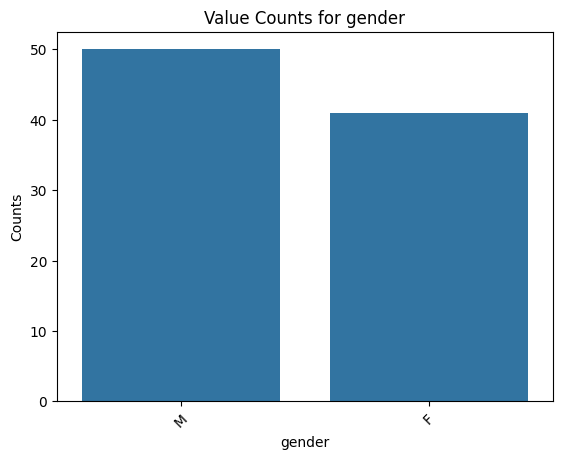

In [66]:
# example: visualize column gender
visualize_col('gender')

/var/folders/pv/hg29j3j512d8wd_qw_8g3msw0000gn/T/ipykernel_42680/2156174395.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name] = pd.to_numeric(df.loc[:,col_name], errors='coerce')


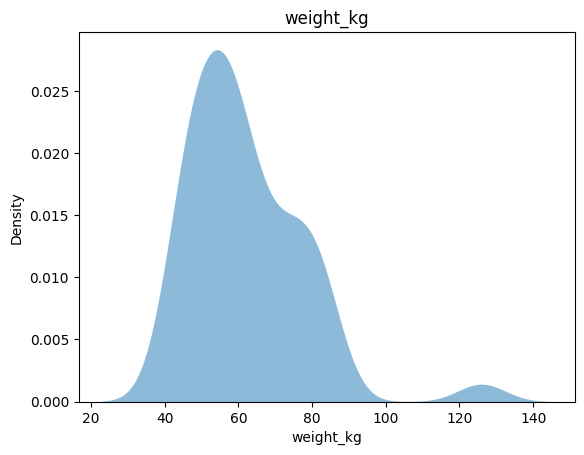

In [47]:
visualize_col('weight_kg')